In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import seaborn as sns
import sys

neuropy_path = Path('/Users/nkinsky/Documents/UM/GitHub/NeuroPy')
eraser_path = Path('/Users/nkinsky/Documents/BU/GitHub/Eraser')
sys.path.append(str(neuropy_path))
sys.path.append(str(eraser_path))
%load_ext autoreload
%autoreload 2

from neuropy.utils.ccg import correlograms
from neuropy.utils.mathutil import contiguous_regions
from neuropy.io.openephysio import get_dat_timestamps
from neuropy.plotting import Fig
from neuropy.io.binarysignalio import BinarysignalIO
from neuropy.plotting.signals import plot_signal_traces
from neuropy.utils.signal_process import filter_sig

# Eraser github imports
from Ephys.ephys import *
# from plotting import Fig, pretty_plot, FigMirror

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# FigS5 = Fig(num="Figure S5", grid=(4, 5), size=(7, 3), fontsize=6)
FigS5 = Fig(num="Figure S5", nrows=4, ncols=5, size=(7, 3), fontsize=6)
print(FigS5.fig.get_size_inches())

[7. 3.]


<Figure size 700x300 with 0 Axes>

In [5]:
fig_save_dir = Path('/Users/nkinsky/Documents/BU/Working/Eraser/plots')

In [6]:
working_dir = Path('/Users/nkinsky/Documents/UM/Working/Anisomycin/Recording_Rats/Wedge')

In [7]:
saline1_folder = '2022_12_12_saline'
ani_folder = '2022_12_13_anisomycin50mg'
saline2_folder = '2022_12_14_saline2'
ani2_folder = '2022_12_15_anisomycin25'
rec_only_folder = '2022_12_16_recordonly'
saline3_folder = '2022_12_21_saline3'


folder_list = [saline1_folder, ani_folder, saline2_folder, saline3_folder]
unit_type = ['single', 'single', 'single', 'single']
session = ['saline1', 'ANI', 'saline2', 'saline3']

In [8]:
ani_timestamps = get_dat_timestamps(working_dir / ani_folder)

start time = 2022-12-13 11:25:07.917000-05:00
start time = 2022-12-13 11:44:12.642000-05:00
start time = 2022-12-13 12:30:43.617000-05:00
start time = 2022-12-13 15:19:03.869000-05:00
start time = 2022-12-13 15:39:55.858000-05:00
start time = 2022-12-13 15:47:14.554000-05:00
start time = 2022-12-13 16:26:18.283000-05:00


In [10]:
corr_by_epoch_ani, time_bins_ani, epochs_used_ani = calc_ccg_by_epoch(ani_folder, timestamps=ani_timestamps)

Calculating CCGs for epoch pre
Calculating CCGs for epoch injection
Calculating CCGs for epoch track 1 (novel)
Calculating CCGs for epoch post
Calculating CCGs for epoch track 2 (new config)
Calculating CCGs for epoch post 2


In [11]:
corr_by_epoch_anic, time_bins_anic, epochs_used_anic = calc_ccg_by_epoch(ani_folder, timestamps=ani_timestamps, 
                                                                        combine_units=True)

Calculating CCGs for epoch pre
Calculating CCGs for epoch injection
Calculating CCGs for epoch track 1 (novel)
Calculating CCGs for epoch post
Calculating CCGs for epoch track 2 (new config)
Calculating CCGs for epoch post 2


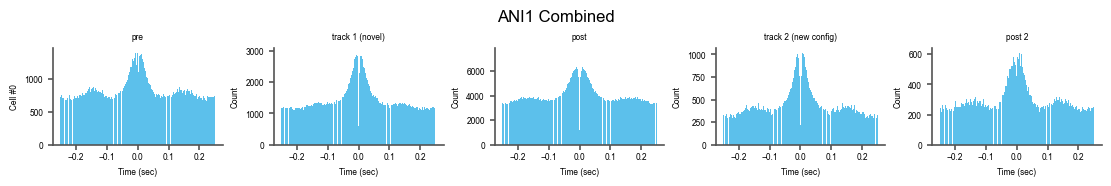

In [12]:
plot_ccg_by_epoch(corr_by_epoch_anic[:, 0, 0, :].reshape((corr_by_epoch_anic.shape[0], 1, 1, corr_by_epoch_anic.shape[3])), 
                  time_bins_anic, epochs_used_anic, 'ANI1 Combined')
plt.gcf().set_size_inches((11, 1.75))

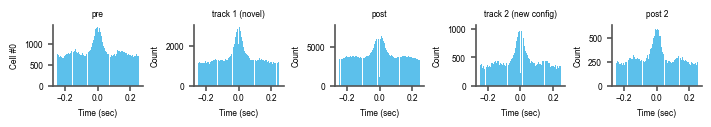

In [13]:
ax_ani1 = []
for i in range(5):
    ax_ani1.append(FigS5.subplot(FigS5.gs[0, i]))
ax_ani1 = np.array(ax_ani1)[None, :]
plot_ccg_by_epoch(corr_by_epoch_anic, time_bins_anic, epochs_used_anic, 'ANI1 combined',
                                    ax=ax_ani1)

FigS5.fig

In [ ]:
# plot_ccg_by_epoch(corr_by_epoch_ani, time_bins_ani, epochs_used_ani, 'ANI1')
# plt.gcf().set_size_inches((10, 12))

### Import eeg file and get raw theta and SWR traces

In [15]:
ani_signal = BinarysignalIO(sorted((working_dir / ani_folder).glob("*.eeg"))[0], n_channels=35, sampling_rate=1250)
print(ani_signal)

duration: 18406.83 seconds 
duration: 5.11 hours 



In [30]:
ani_epochs = load_events_csv(ani_folder, start_time=ani_timestamps.iloc[0])
ani_epochs

,start,stop,label
0,2022-12-13 11:25:00-05:00,2022-12-13 11:41:50-05:00,pre
1,2022-12-13 11:42:00-05:00,2022-12-13 11:42:10-05:00,injection
2,2022-12-13 11:44:00-05:00,2022-12-13 12:30:00-05:00,track 1 (novel)
3,2022-12-13 12:30:43-05:00,2022-12-13 15:46:40-05:00,post
4,2022-12-13 15:47:00-05:00,2022-12-13 16:25:40-05:00,track 2 (new config)
5,2022-12-13 16:26:00-05:00,2022-12-13 16:41:00-05:00,post 2


(-2.3360459973463072, 2.6827952233524988)

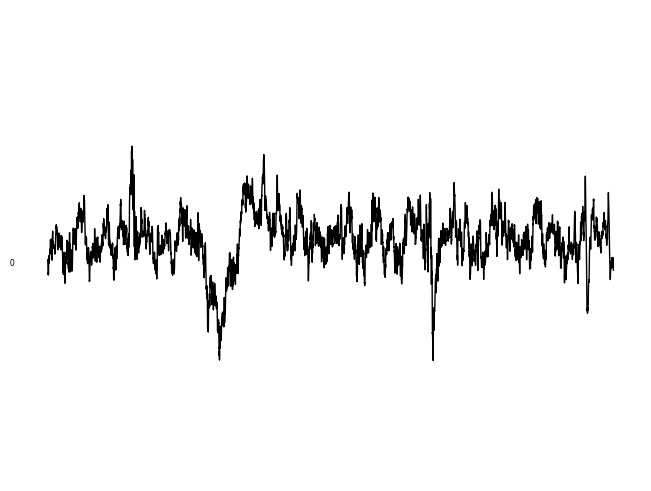

In [31]:
def get_epoch_signal(signal, epoch, epochs_df, channel_indx=None, SR=30000):
    SR = 30000
    epochs = epochs_df
    ts = ani_timestamps.squeeze()
    epoch_use = epochs[epochs['label'] == epoch]
    start_sec = ts.searchsorted(epoch_use['start'])/SR
    stop_sec = ts.searchsorted(epoch_use['stop'])/SR

    return signal.get_signal(channel_indx=channel_indx, t_start=start_sec, t_stop=stop_sec)

# Make sure it is working well by plotting
pre_theta = get_epoch_signal(ani_signal, 'pre', ani_epochs, channel_indx=4)
ax = plot_signal_traces(pre_theta.time_slice(t_start=395, t_stop=400))
ax.set_ylim(np.array(ax.get_ylim())*2)

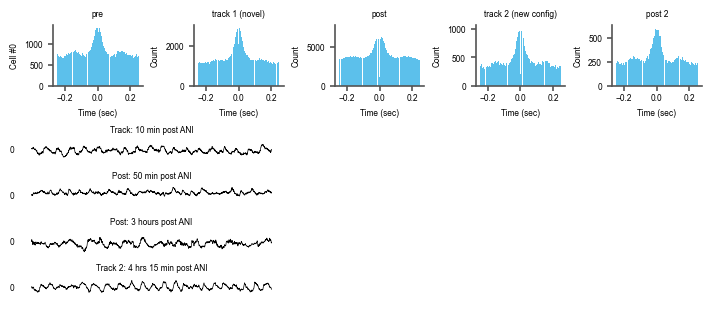

In [32]:
ax_theta = FigS5.subplot2grid(FigS5.gs[1:, 0:2], grid=(4, 1), return_axes=True)

### TODO: set ylim to be all the same
track_theta = get_epoch_signal(ani_signal, 'track 1 (novel)', ani_epochs, channel_indx=4)
post_theta = get_epoch_signal(ani_signal, 'post', ani_epochs, channel_indx=4)
post_hp = filter_sig.highpass(post_theta, cutoff=2)  # highpass filter to get rid of floating ground issue in homecage
track2_theta = get_epoch_signal(ani_signal, 'track 2 (new config)', ani_epochs, channel_indx=4)

# Track 10 min post ANI
plot_signal_traces(track_theta.time_slice(t_start=1529, t_stop=1532), ax=ax_theta[0], lw=0.5)
ax_theta[0].set_title('Track: 10 min post ANI')

# Post 50 min post ANI
plot_signal_traces(post_hp.time_slice(t_start=3829, t_stop=3833), ax=ax_theta[1], lw=0.5)
ax_theta[1].set_title('Post: 50 min post ANI')
ax_theta[1].sharey(ax_theta[0])

# Post 3 hrs post ANI
# ax = plot_signal_traces(post_hp.time_slice(t_start=11780, t_stop=11783), ax=ax_theta[2])
# plot_signal_traces(post_hp.time_slice(t_start=12986, t_stop=12989), ax=ax_theta[2])
plot_signal_traces(post_hp.time_slice(t_start=13000, t_stop=13003), ax=ax_theta[2], lw=0.5)
# plot_signal_traces(post_hp.time_slice(t_start=13319, t_stop=13322), ax=ax_theta[2])
ax_theta[2].set_title('Post: 3 hours post ANI')
ax_theta[2].sharey(ax_theta[0])

# 4 hours 15 min in, so 4 hours post.  Theta still there.
plot_signal_traces(track2_theta.time_slice(t_start=15372, t_stop=15375), ax=ax_theta[3], lw=0.5)
ax_theta[3].set_title('Track 2: 4 hrs 15 min post ANI')
ax_theta[3].sharey(ax_theta[0])

ax_theta[3].set_ylim(np.array(ax_theta[3].get_ylim())*1.6)
FigS5.fig

## Now grab some ripples

In [33]:
swr_track = get_epoch_signal(ani_signal, 'track 1 (novel)', ani_epochs, channel_indx=[1, 2, 3, 4, 5, 6, 7, 8, 9])
swr_post = get_epoch_signal(ani_signal, 'post', ani_epochs, channel_indx=[1, 2, 3, 4, 5, 6, 7, 8, 9])
swr_track2 = get_epoch_signal(ani_signal, 'track 2 (new config)', ani_epochs, 
                              channel_indx=[1, 2, 3, 4, 5, 6, 7, 8, 9])

In [34]:
ax_swr = FigS5.subplot2grid(FigS5.gs[1:, 2:], grid=(1, 4), return_axes=True)

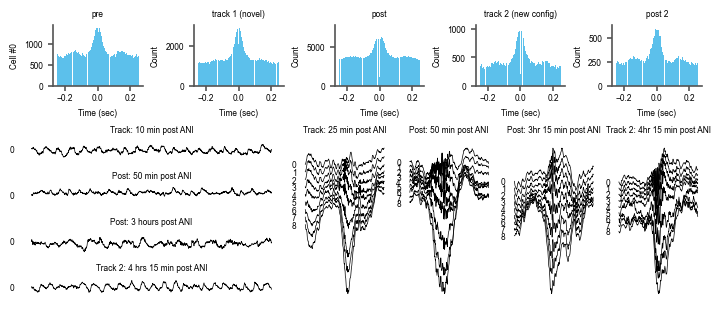

In [35]:
# Track - 25 min post injection
plot_signal_traces(swr_track.time_slice(t_start=2295.30, t_stop=2295.6), ax=ax_swr[0], lw=0.5)
ax_swr[0].set_title('Track: 25 min post ANI')

# Post: 50 min post
plot_signal_traces(swr_post.time_slice(t_start=3963.3, t_stop=3963.6), ax=ax_swr[1], lw=0.5)
ax_swr[1].set_title('Post: 50 min post ANI')

# Post: ~195 min post
plot_signal_traces(swr_post.time_slice(t_start=12570.1, t_stop=12570.4), ax=ax_swr[2], lw=0.5)
ax_swr[2].set_title('Post: 3hr 15 min post ANI')


# Track 2: 265 min post
plot_signal_traces(swr_track2.time_slice(t_start=16943.3, t_stop=16943.6), ax=ax_swr[3], lw=0.5)
ax_swr[3].set_title('Track 2: 4hr 15 min post ANI')


FigS5.fig

In [36]:
FigS5.savefig(fig_save_dir / 'Figure S5.pdf')